# Gender Detection

<div class="alert alert-info">

This tutorial is available as an IPython notebook at [malaya-speech/example/gender](https://github.com/huseinzol05/malaya-speech/tree/master/example/gender-detection).
    
</div>

<div class="alert alert-info">

This module is language independent, so it save to use on different languages. Pretrained models trained on multilanguages.
    
</div>

<div class="alert alert-warning">

This is an application of malaya-speech Pipeline, read more about malaya-speech Pipeline at [malaya-speech/example/pipeline](https://github.com/huseinzol05/malaya-speech/tree/master/example/pipeline).
    
</div>

### Dataset

Trained on Gender column from Common Voice Mozilla Dataset and VoxCeleb 1 with augmented noises, https://commonvoice.mozilla.org/, http://www.robots.ox.ac.uk/~vgg/data/voxceleb/vox1.html

In [1]:
import malaya_speech
import numpy as np
from malaya_speech import Pipeline

In [2]:
y, sr = malaya_speech.load('speech/video/The-Singaporean-White-Boy.wav')
len(y), sr

(1634237, 16000)

In [3]:
# just going to take 30 seconds
y = y[:sr * 30]

In [4]:
import IPython.display as ipd
ipd.Audio(y, rate = sr)

This audio extracted from https://www.youtube.com/watch?v=HylaY5e1awo&t=2s

### Supported genders

In [5]:
malaya_speech.gender.labels

['male', 'female', 'not a gender']

### List available deep model

In [6]:
malaya_speech.gender.available_model()

INFO:root:last accuracy during training session before early stopping.


,Size (MB),Quantized Size (MB),Accuracy
vggvox-v2,31.1,7.92,0.9756
deep-speaker,96.9,24.40,0.9455


### Load deep model

```python
def deep_model(model: str = 'vggvox-v2', quantized: bool = False, **kwargs):
    """
    Load gender detection deep model.

    Parameters
    ----------
    model : str, optional (default='vggvox-v2')
        Model architecture supported. Allowed values:

        * ``'vggvox-v2'`` - finetuned VGGVox V2.
        * ``'deep-speaker'`` - finetuned Deep Speaker.
    quantized : bool, optional (default=False)
        if True, will load 8-bit quantized model. 
        Quantized model not necessary faster, totally depends on the machine.

    Returns
    -------
    result : malaya_speech.supervised.classification.load function
    """
```

In [7]:
vggvox_v2 = malaya_speech.gender.deep_model(model = 'vggvox-v2')
deep_speaker = malaya_speech.gender.deep_model(model = 'deep-speaker')


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


### Load Quantized deep model

To load 8-bit quantized model, simply pass `quantized = True`, default is `False`.

We can expect slightly accuracy drop from quantized model, and not necessary faster than normal 32-bit float model, totally depends on machine.

In [8]:
quantized_vggvox_v2 = malaya_speech.gender.deep_model(model = 'vggvox-v2', quantized = True)

### How to classify genders in an audio sample

So we are going to use VAD to help us. Instead we are going to classify as a whole sample, we chunk it into multiple small samples and classify it.

In [9]:
vad = malaya_speech.vad.deep_model(model = 'vggvox-v2')

In [10]:
%%time

frames = list(malaya_speech.utils.generator.frames(y, 30, sr))

CPU times: user 1.45 ms, sys: 71 µs, total: 1.52 ms
Wall time: 1.53 ms


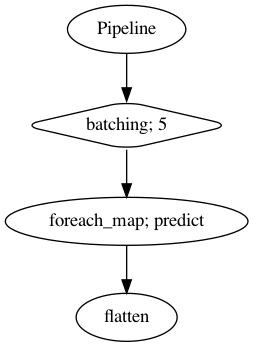

In [11]:
p = Pipeline()
pipeline = (
    p.batching(5)
    .foreach_map(vad.predict)
    .flatten()
)
p.visualize()

In [12]:
%%time

result = p.emit(frames)
result.keys()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=512 is too small for input signal of length=480
  n_fft, y.shape[-1]


CPU times: user 32.1 s, sys: 5.49 s, total: 37.5 s
Wall time: 7.8 s


dict_keys(['batching', 'predict', 'flatten'])

In [13]:
frames_vad = [(frame, result['flatten'][no]) for no, frame in enumerate(frames)]
grouped_vad = malaya_speech.utils.group.group_frames(frames_vad)
grouped_vad = malaya_speech.utils.group.group_frames_threshold(grouped_vad, threshold_to_stop = 0.3)

In [14]:
malaya_speech.extra.visualization.visualize_vad(y, grouped_vad, sr, figsize = (15, 3))

<Figure size 1500x300 with 1 Axes>

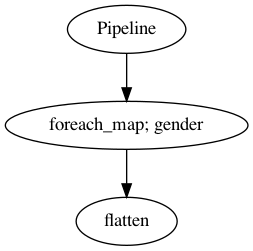

In [15]:
p_vggvox_v2 = Pipeline()
pipeline = (
    p_vggvox_v2.foreach_map(vggvox_v2)
    .flatten()
)
p_vggvox_v2.visualize()

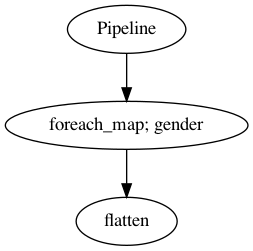

In [16]:
p_deep_speaker = Pipeline()
pipeline = (
    p_deep_speaker.foreach_map(deep_speaker)
    .flatten()
)
p_deep_speaker.visualize()

In [17]:
%%time

samples_vad = [g[0] for g in grouped_vad]
result_vggvox_v2 = p_vggvox_v2.emit(samples_vad)
result_vggvox_v2.keys()

CPU times: user 4.68 s, sys: 906 ms, total: 5.58 s
Wall time: 1.38 s


dict_keys(['gender', 'flatten'])

In [18]:
%%time

samples_vad = [g[0] for g in grouped_vad]
result_deep_speaker = p_deep_speaker.emit(samples_vad)
result_deep_speaker.keys()

CPU times: user 5.03 s, sys: 821 ms, total: 5.85 s
Wall time: 1.59 s


dict_keys(['gender', 'flatten'])

In [19]:
samples_vad_vggvox_v2 = [(frame, result_vggvox_v2['flatten'][no]) for no, frame in enumerate(samples_vad)]
samples_vad_vggvox_v2

[(<malaya_speech.model.frame.Frame at 0x153041ad0>, 'not a gender'),
 (<malaya_speech.model.frame.Frame at 0x1509f7150>, 'not a gender'),
 (<malaya_speech.model.frame.Frame at 0x1509f7190>, 'male'),
 (<malaya_speech.model.frame.Frame at 0x1509f7450>, 'male'),
 (<malaya_speech.model.frame.Frame at 0x150f92d50>, 'male'),
 (<malaya_speech.model.frame.Frame at 0x153052b90>, 'male'),
 (<malaya_speech.model.frame.Frame at 0x153052bd0>, 'male'),
 (<malaya_speech.model.frame.Frame at 0x153052c10>, 'male'),
 (<malaya_speech.model.frame.Frame at 0x153052c90>, 'male'),
 (<malaya_speech.model.frame.Frame at 0x153052c50>, 'female'),
 (<malaya_speech.model.frame.Frame at 0x153052ad0>, 'female'),
 (<malaya_speech.model.frame.Frame at 0x153052cd0>, 'not a gender'),
 (<malaya_speech.model.frame.Frame at 0x153052d10>, 'female'),
 (<malaya_speech.model.frame.Frame at 0x153052d50>, 'female'),
 (<malaya_speech.model.frame.Frame at 0x153052d90>, 'not a gender'),
 (<malaya_speech.model.frame.Frame at 0x15305

In [20]:
samples_vad_deep_speaker = [(frame, result_deep_speaker['flatten'][no]) for no, frame in enumerate(samples_vad)]
samples_vad_deep_speaker

[(<malaya_speech.model.frame.Frame at 0x153041ad0>, 'not a gender'),
 (<malaya_speech.model.frame.Frame at 0x1509f7150>, 'not a gender'),
 (<malaya_speech.model.frame.Frame at 0x1509f7190>, 'male'),
 (<malaya_speech.model.frame.Frame at 0x1509f7450>, 'male'),
 (<malaya_speech.model.frame.Frame at 0x150f92d50>, 'male'),
 (<malaya_speech.model.frame.Frame at 0x153052b90>, 'male'),
 (<malaya_speech.model.frame.Frame at 0x153052bd0>, 'male'),
 (<malaya_speech.model.frame.Frame at 0x153052c10>, 'male'),
 (<malaya_speech.model.frame.Frame at 0x153052c90>, 'male'),
 (<malaya_speech.model.frame.Frame at 0x153052c50>, 'female'),
 (<malaya_speech.model.frame.Frame at 0x153052ad0>, 'female'),
 (<malaya_speech.model.frame.Frame at 0x153052cd0>, 'not a gender'),
 (<malaya_speech.model.frame.Frame at 0x153052d10>, 'female'),
 (<malaya_speech.model.frame.Frame at 0x153052d50>, 'female'),
 (<malaya_speech.model.frame.Frame at 0x153052d90>, 'female'),
 (<malaya_speech.model.frame.Frame at 0x153052e10>,

In [21]:
import matplotlib.pyplot as plt

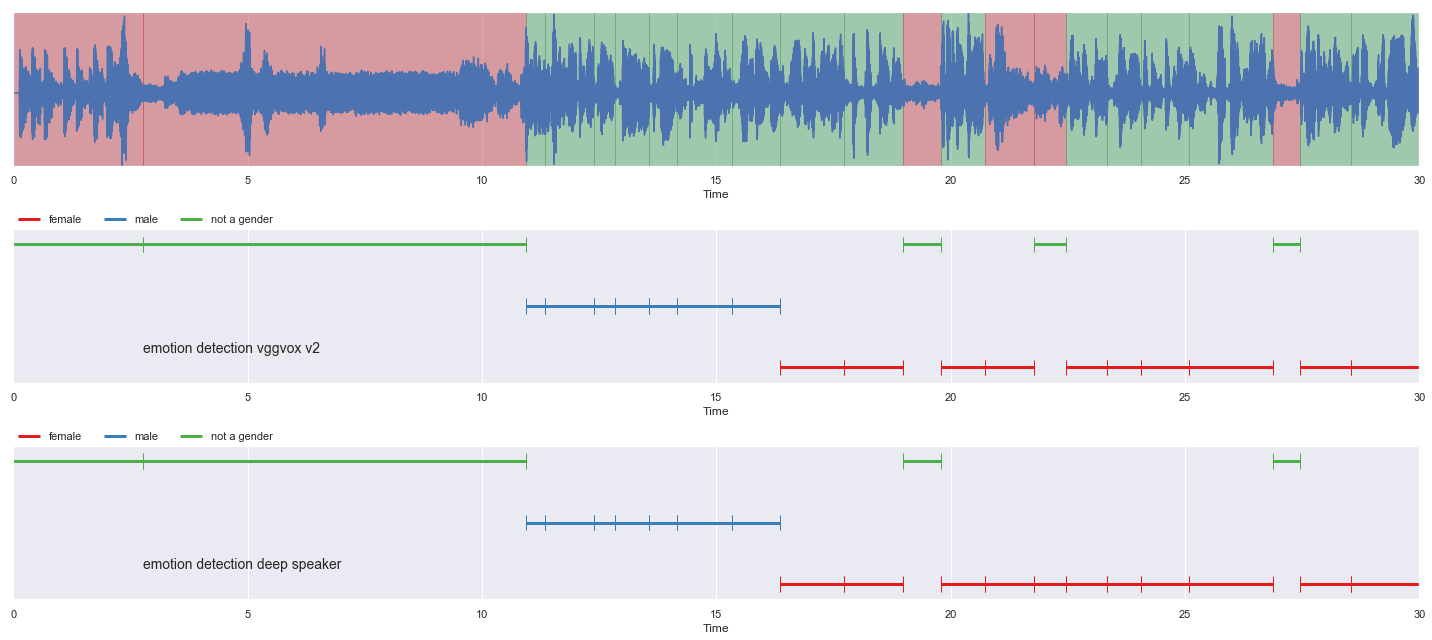

In [22]:
nrows = 3
fig, ax = plt.subplots(nrows = nrows, ncols = 1)
fig.set_figwidth(20)
fig.set_figheight(nrows * 3)
malaya_speech.extra.visualization.visualize_vad(y, grouped_vad, sr, ax = ax[0])
malaya_speech.extra.visualization.plot_classification(samples_vad_vggvox_v2, 
                                                      'emotion detection vggvox v2', ax = ax[1])
malaya_speech.extra.visualization.plot_classification(samples_vad_deep_speaker, 
                                                      'emotion detection deep speaker', ax = ax[2])
fig.tight_layout()
plt.show()

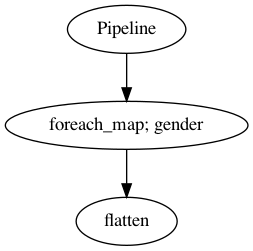

In [23]:
p_quantized_vggvox_v2 = Pipeline()
pipeline = (
    p_quantized_vggvox_v2.foreach_map(quantized_vggvox_v2)
    .flatten()
)
p_quantized_vggvox_v2.visualize()

In [24]:
%%time

samples_vad = [g[0] for g in grouped_vad]
result_quantized_vggvox_v2 = p_quantized_vggvox_v2.emit(samples_vad)
result_quantized_vggvox_v2.keys()

CPU times: user 4.69 s, sys: 880 ms, total: 5.57 s
Wall time: 1.35 s


dict_keys(['gender', 'flatten'])

In [25]:
samples_vad_quantized_vggvox_v2 = [(frame, result_quantized_vggvox_v2['flatten'][no]) for no, frame in enumerate(samples_vad)]
samples_vad_quantized_vggvox_v2

[(<malaya_speech.model.frame.Frame at 0x153041ad0>, 'not a gender'),
 (<malaya_speech.model.frame.Frame at 0x1509f7150>, 'not a gender'),
 (<malaya_speech.model.frame.Frame at 0x1509f7190>, 'male'),
 (<malaya_speech.model.frame.Frame at 0x1509f7450>, 'male'),
 (<malaya_speech.model.frame.Frame at 0x150f92d50>, 'male'),
 (<malaya_speech.model.frame.Frame at 0x153052b90>, 'male'),
 (<malaya_speech.model.frame.Frame at 0x153052bd0>, 'male'),
 (<malaya_speech.model.frame.Frame at 0x153052c10>, 'male'),
 (<malaya_speech.model.frame.Frame at 0x153052c90>, 'male'),
 (<malaya_speech.model.frame.Frame at 0x153052c50>, 'female'),
 (<malaya_speech.model.frame.Frame at 0x153052ad0>, 'female'),
 (<malaya_speech.model.frame.Frame at 0x153052cd0>, 'not a gender'),
 (<malaya_speech.model.frame.Frame at 0x153052d10>, 'female'),
 (<malaya_speech.model.frame.Frame at 0x153052d50>, 'female'),
 (<malaya_speech.model.frame.Frame at 0x153052d90>, 'not a gender'),
 (<malaya_speech.model.frame.Frame at 0x15305

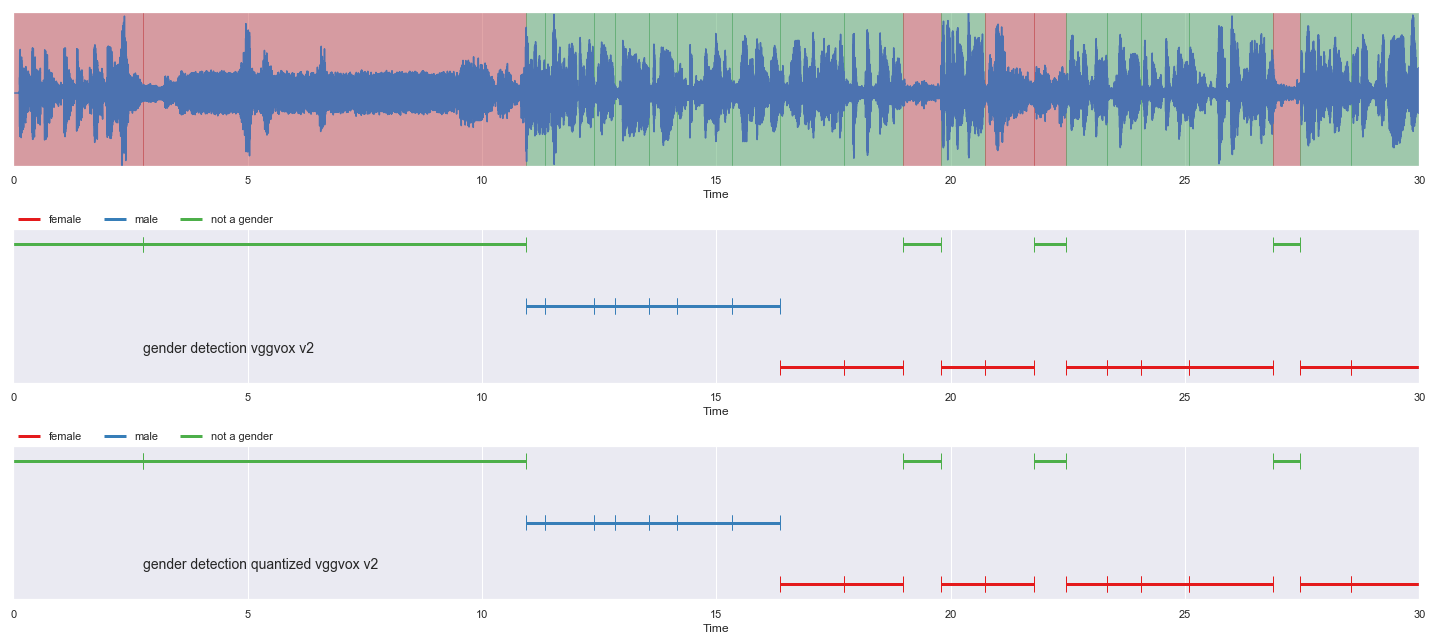

In [26]:
nrows = 3
fig, ax = plt.subplots(nrows = nrows, ncols = 1)
fig.set_figwidth(20)
fig.set_figheight(nrows * 3)
malaya_speech.extra.visualization.visualize_vad(y, grouped_vad, sr, ax = ax[0])
malaya_speech.extra.visualization.plot_classification(samples_vad_vggvox_v2, 
                                                      'gender detection vggvox v2', ax = ax[1])
malaya_speech.extra.visualization.plot_classification(samples_vad_quantized_vggvox_v2, 
                                                      'gender detection quantized vggvox v2', ax = ax[2])
fig.tight_layout()
plt.show()

### Reference

1. The Singaporean White Boy - The Shan and Rozz Show: EP7, https://www.youtube.com/watch?v=HylaY5e1awo&t=2s&ab_channel=Clicknetwork
2. Common Voice dataset, https://commonvoice.mozilla.org/